# Environment

### Downloads

In [ ]:
!pip install gym
!pip install "stable-baselines3[extra]>=2.0.0a4"

### Imports

In [4]:
import gym
from gym import Env, spaces
import numpy as np
from stable_baselines3 import PPO

# Utilidad
import json
import copy # Para copiar las variables originales a las que el ambiente edite para cuando se haga un reset
import random
import os
import csv

2024-09-11 22:39:55.339287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-11 22:39:55.375727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 22:39:56.022906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Funciones útiles

In [21]:
# Función para encontrar el siguiente nombre de archivo disponible
def get_next_model_filename(base_name="ppo_model", folder="models"):
    # Obtén todos los archivos en la carpeta
    files = os.listdir(folder)

    # Filtra los archivos que comienzan con el nombre base
    model_files = [f for f in files if f.startswith(base_name)]

    # Encuentra el número más alto entre las versiones existentes
    max_version = 0
    for f in model_files:
        try:
            version = int(f[len(base_name):].replace(".zip", "").replace("_v", ""))
            max_version = max(max_version, version)
        except ValueError:
            pass

    # Genera el nuevo nombre con la siguiente versión
    next_version = max_version + 1
    new_filename = f"{base_name}_v{next_version}.zip"

    return os.path.join(folder, new_filename)

# Función para encontrar el nombre del archivo con la versión más alta
def get_latest_model_filename(base_name="ppo_model", folder="models"):
    # Obtén todos los archivos en la carpeta
    files = os.listdir(folder)

    # Filtra los archivos que comienzan con el nombre base
    model_files = [f for f in files if f.startswith(base_name)]

    # Si no hay archivos, devuelve None
    if not model_files:
        return None

    # Encuentra el número más alto entre las versiones existentes
    max_version = 0
    latest_file = None
    for f in model_files:
        try:
            version = int(f[len(base_name):].replace(".zip", "").replace("_v", ""))
            if version > max_version:
                max_version = version
                latest_file = f
        except ValueError:
            pass

    return os.path.join(folder, latest_file) if latest_file else None

### Definición

In [9]:
preferencias = [
    [1,2,3,0],
    [0,3,2,1],
    [3,2,1,0]
]

state = [
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
]

observation = [
    preferencias, state
]

# Ambiente sin restricciones de cuantos alumnos hay por grupo

In [4]:
class OrganizationEnvironment(gym.Env):
    def __init__(self, preferencias = None, rendering = False):
        super(OrganizationEnvironment, self).__init__()

        self.all_rewards = []
        self.rendering = rendering

        if(preferencias == None):
            self.preferencias = self.get_preferencias()
        else:
            self.preferencias = preferencias

        self.num_estudiantes = len(self.preferencias)
        self.num_desafios = len(self.preferencias[0])

        self.num_preferencias = 0
        for i in self.preferencias:
            for j in i:
                if j > self.num_preferencias:
                    self.num_preferencias = j


        self.state = [[ 0 for _ in range(self.num_desafios)] for _ in range(self.num_estudiantes)]
        self.current_ids = list(range(len(self.preferencias)))
        self.reset()

        # Definición de espacio de observación
        self.observation_space = spaces.MultiDiscrete([2] * (self.num_estudiantes * self.num_desafios) + \
                                                      [self.num_desafios] * (self.num_estudiantes * self.num_desafios))
        # Definición de espacio de acción
        self.action_space = spaces.MultiDiscrete([self.num_estudiantes, self.num_desafios])


    def get_preferencias(self):
        num_estudiantes = 12
        num_desafios = 9

        preferencias_totales = []

        for i in range(num_estudiantes):
            preferencias_estudiante = [0] * (num_desafios)
            numero_preferencia = 1

            while True:
                desafio = random.randint(0, num_desafios - 1)
                if(preferencias_estudiante[desafio] == 0):
                    preferencias_estudiante[desafio] = numero_preferencia
                    numero_preferencia += 1
                if(numero_preferencia > 5):
                    break
            preferencias_totales.append(preferencias_estudiante)

        if(self.rendering):
            print("\t      Preferencias")
            for index, fila in enumerate(preferencias_totales):
                print(f"Alumno {index}: ",fila)

        return preferencias_totales

    def render(self):
        print("\t\t Desafíos\t\t\t Preferencias")
        for index, fila in enumerate(self.state):
            print(f"Alumno {index}: \t",fila,"\t",self.preferencias[index])

    def reset(self):

        last_observation = self._get_observation()

        self.lives = 3
        self.racha_de_aciertos = 0
        self.preferencias = self.get_preferencias()
        self.reward_acumulado = 0
        self.num_estudiantes = len(self.preferencias)
        self.num_desafios = len(self.preferencias[0])

        self.num_preferencias = 0
        for i in self.preferencias:
            for j in i:
                if j > self.num_preferencias:
                    self.num_preferencias = j


        # Espacio de observación
        self.state = [[ 0 for _ in range(self.num_desafios)] for _ in range(self.num_estudiantes)]
        self.current_ids = list(range(len(self.preferencias)))

        return last_observation

    def step(self, action):
        assert self.action_space.contains(action), "Invalid Action"

        id_estudiante = action[0]
        id_desafio = action[1]

        done = self.check_done()

        if self._chech_possible(id_estudiante, id_desafio):

            self.state[id_estudiante][id_desafio] = 1

            if(not done):
                contador_escogidos = 0
                for estudiante in self.state:
                    for desafio in estudiante:
                        contador_escogidos += desafio

            reward = self.get_reward([id_estudiante, id_desafio])

        else:
            self.lives -= 1
            reward = -10 #- (3 - self.lives)

        if not(self.lives > 0):
            done = True
            # reward = -90
        done = self.check_done()
        self.reward_acumulado += reward
        # observation = [self.state, self.preferencias]
        observation = self._get_observation()
        info = {}

        if done:
            self.all_rewards.append(self.reward_acumulado)
            return observation, self.reward_acumulado, done, info
        return observation, reward, done, info


    def _chech_possible(self, id_estudiante, id_desafio):
        # Ver si el estudiante ya esta dentro de un desafío
        total_desafios_asignados = 0
        for desafio_estudiante in self.state[id_estudiante]:
            total_desafios_asignados += desafio_estudiante
        if(total_desafios_asignados > 0):
            return False

        return True

    def _get_observation(self):
        # Aplanar el estado y las preferencias para ajustarse al espacio de observación
        return [self.state[i][j] for i in range(self.num_estudiantes) for j in range(self.num_desafios)] + \
               [self.preferencias[i][j] for i in range(self.num_estudiantes) for j in range(self.num_desafios)]

    def get_reward(self, action):
        id_estudiante = action[0]
        id_desafio = action[1]

        reward = 0
        # Reward por las preferencias
        reward +=   (self.num_preferencias - self.preferencias[id_estudiante][id_desafio] + 1)*2 \
                    if self.preferencias[id_estudiante][id_desafio] != 0 \
                    else -1


        # # Reward por racha de aciertos
        # if(reward > 0):
        #     self.racha_de_aciertos += 1
        #     reward = reward + self.racha_de_aciertos
        # else:
        #     self.racha_de_aciertos = 0
        # Implementar función de reward
        return reward

    def check_done(self):
        # Condición para finalizar el episodio
        contador_de_estudiantes = 0
        for estudiante in self.state:
            for seleccion in estudiante:
                contador_de_estudiantes += seleccion

        if(contador_de_estudiantes == self.num_estudiantes):
            return True

        return False

env = OrganizationEnvironment()

# Ambiente con restriccion de cuantas personas pueden ingresar a un equipo

In [34]:
class OrganizationEnvironment(gym.Env):
    def __init__(self, preferencias = None, rendering = False):
        super(OrganizationEnvironment, self).__init__()

        self.all_rewards = []
        self.rendering = rendering

        if(preferencias == None):
            self.preferencias = self.get_preferencias()
        else:
            self.preferencias = preferencias

        self.num_estudiantes = len(self.preferencias)
        self.num_desafios = len(self.preferencias[0])

        self.num_preferencias = 0
        for i in self.preferencias:
            for j in i:
                if j > self.num_preferencias:
                    self.num_preferencias = j


        self.state = [[ 0 for _ in range(self.num_desafios)] for _ in range(self.num_estudiantes)]
        self.current_ids = list(range(len(self.preferencias)))
        self.reset()

        # Definición de espacio de observación
        self.observation_space = spaces.MultiDiscrete([2] * (self.num_estudiantes * self.num_desafios) + \
                                                      [self.num_desafios] * (self.num_estudiantes * self.num_desafios))
        # Definición de espacio de acción
        self.action_space = spaces.MultiDiscrete([self.num_estudiantes, self.num_desafios])


    def get_preferencias(self):
        num_estudiantes = 12
        num_desafios = 9

        preferencias_totales = []

        for i in range(num_estudiantes):
            preferencias_estudiante = [0] * (num_desafios)
            numero_preferencia = 1
            numero_preferencias_max = random.randint(3, 5)
            while True:
                desafio = random.randint(0, num_desafios - 1)
                if(preferencias_estudiante[desafio] == 0):
                    preferencias_estudiante[desafio] = numero_preferencia
                    numero_preferencia += 1
                if(numero_preferencia > numero_preferencias_max):
                    break
            preferencias_totales.append(preferencias_estudiante)

        if(self.rendering):
            print("\t      Preferencias")
            for index, fila in enumerate(preferencias_totales):
                print(f"Alumno {index}: ",fila)

        return preferencias_totales

    def render(self):
        print("\t\t Desafíos\t\t\t Preferencias")
        for index, fila in enumerate(self.state):
            print(f"Alumno {index}: \t",fila,"\t",self.preferencias[index])

    def reset(self):

        last_observation = self._get_observation()

        self.lives = 3
        self.racha_de_aciertos = 0
        self.preferencias = self.get_preferencias()
        self.reward_acumulado = 0
        self.num_estudiantes = len(self.preferencias)
        self.num_desafios = len(self.preferencias[0])

        self.num_preferencias = 0
        for i in self.preferencias:
            for j in i:
                if j > self.num_preferencias:
                    self.num_preferencias = j


        # Espacio de observación
        self.state = [[ 0 for _ in range(self.num_desafios)] for _ in range(self.num_estudiantes)]
        self.current_ids = list(range(len(self.preferencias)))

        return last_observation

    def step(self, action):
        assert self.action_space.contains(action), "Invalid Action"

        id_estudiante = action[0]
        id_desafio = action[1]

        done = self.check_done()

        if self._chech_possible(id_estudiante, id_desafio):

            self.state[id_estudiante][id_desafio] = 1

            if(not done):
                contador_escogidos = 0
                for estudiante in self.state:
                    for desafio in estudiante:
                        contador_escogidos += desafio

            reward = self.get_reward([id_estudiante, id_desafio])

        else:
            self.lives -= 1
            # print("PERDIO UNA VIDA ", self.lives)
            reward = -10 #- (3 - self.lives)

        done = self.check_done()

        if not(self.lives > 0):
            done = True
            # reward = -90
        self.reward_acumulado += reward
        # observation = [self.state, self.preferencias]
        observation = self._get_observation()
        info = {}

        if done:
            self.all_rewards.append(self.reward_acumulado)
            return observation, self.reward_acumulado, done, info
        return observation, reward, done, info


    def _chech_possible(self, id_estudiante, id_desafio):
        # Ver si el estudiante ya esta dentro de un desafío
        total_desafios_asignados = 0
        for desafio_estudiante in self.state[id_estudiante]:
            total_desafios_asignados += desafio_estudiante
        if(total_desafios_asignados > 0):
            return False

        return True

    def _get_observation(self):
        # Aplanar el estado y las preferencias para ajustarse al espacio de observación
        return [self.state[i][j] for i in range(self.num_estudiantes) for j in range(self.num_desafios)] + \
               [self.preferencias[i][j] for i in range(self.num_estudiantes) for j in range(self.num_desafios)]

    def get_reward(self, action):
        id_estudiante = action[0]
        id_desafio = action[1]

        reward = 0
        # Reward por las preferencias
        reward +=   (self.num_preferencias - self.preferencias[id_estudiante][id_desafio] + 1)*2 \
                    if self.preferencias[id_estudiante][id_desafio] != 0 \
                    else -1


        # Reward por máximo de personas por grupo
        MAXIMO_ESTUDIANTES = 3
        contador_estudiates = 0
        for desafios in self.state:
            contador_estudiates += desafios[id_desafio]

        if(contador_estudiates > MAXIMO_ESTUDIANTES):
            reward -= (contador_estudiates - MAXIMO_ESTUDIANTES) * 2

        return reward

    def check_done(self):
        # Condición para finalizar el episodio
        contador_de_estudiantes = 0
        for estudiante in self.state:
            for seleccion in estudiante:
                contador_de_estudiantes += seleccion

        if(contador_de_estudiantes == self.num_estudiantes):
            return True

        return False

env = OrganizationEnvironment()

In [35]:
env.reset()
while True:
    action = env.action_space.sample()

    obs, reward, done, info = env.step(action)

    print("\n\n")
    print("Acción:", action,"-> Reward:", reward)
    env.render()

    if done == True:
        break

# print(binary_to_dict2(obs))




Acción: [4 5] -> Reward: -1
		 Desafíos			 Preferencias
Alumno 0: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [3, 0, 0, 4, 1, 2, 0, 0, 0]
Alumno 1: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [2, 1, 0, 4, 0, 0, 0, 3, 0]
Alumno 2: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [3, 0, 1, 0, 0, 0, 0, 0, 2]
Alumno 3: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 5, 3, 0, 2, 0, 1, 0, 4]
Alumno 4: 	 [0, 0, 0, 0, 0, 1, 0, 0, 0] 	 [2, 3, 0, 1, 0, 0, 0, 0, 0]
Alumno 5: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 0, 4, 2, 0, 0, 3, 1, 5]
Alumno 6: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 1, 0, 0, 5, 0, 4, 3, 2]
Alumno 7: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 0, 0, 0, 0, 0, 3, 1, 2]
Alumno 8: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 1, 2, 0, 4, 0, 3, 0, 0]
Alumno 9: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 3, 0, 0, 4, 2, 1, 0, 0]
Alumno 10: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [2, 3, 0, 0, 0, 0, 0, 1, 0]
Alumno 11: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 5, 3, 0, 4, 0, 2, 1, 0]



Acción: [9 5] -> Reward: 8
		 Desafíos			 Preferencias
Alumno 0: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	

In [17]:
env.observation_space.sample()

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 6,
       5, 8, 8, 8, 5, 7, 1, 4, 3, 0, 3, 5, 7, 2, 0, 2, 7, 2, 7, 4, 5, 7,
       7, 8, 3, 4, 2, 0, 7, 4, 2, 2, 6, 1, 5, 0, 8, 4, 2, 1, 5, 1, 8, 4,
       2, 3, 2, 4, 2, 3, 4, 1, 0, 3, 4, 6, 8, 2, 0, 5, 2, 4, 3, 1, 6, 5,
       2, 7, 2, 5, 2, 8, 3, 3, 4, 0, 6, 0, 3, 5, 5, 5, 8, 8, 4, 2, 5, 6,
       3, 4, 5, 5, 1, 6, 0, 2, 4, 8, 6, 5, 3, 5, 2, 8, 4, 1])

Entrenamiento

In [22]:
BASE_NAME = "ppo_model_E2"

# Obtén el archivo de la última versión
latest_model_filename = get_latest_model_filename(base_name=BASE_NAME)

# Carga el modelo si existe
if latest_model_filename:
    print(f"Cargando modelo: {latest_model_filename}")
    model = PPO.load(latest_model_filename, env=env)
else:
    print("No se encontró ningún modelo anterior, entrenando desde cero.")
    model = PPO("MlpPolicy", env)

model.learn(total_timesteps=10_000)

# Obtén el siguiente nombre de archivo disponible
model_filename = get_next_model_filename(base_name=BASE_NAME)

# Guarda el modelo
model.save(model_filename)
print(f"Modelo guardado en: {model_filename}")

No se encontró ningún modelo anterior, entrenando desde cero.


/home/javo/.local/lib/python3.8/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Modelo guardado en: models/ppo_model_E2_v1.zip


In [23]:
# Guardar los rewards en un archivo CSV
def save_rewards_to_csv(rewards, filename="rewards.csv"):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Episode", "Reward"])  # Escribir encabezado

        # Escribir cada episodio y su respectivo reward
        for i, reward in enumerate(rewards):
            writer.writerow([i + 1, reward])

# Guarda los rewards en un archivo CSV
save_rewards_to_csv(env.all_rewards, filename=f"{model_filename}.csv")
print("Rewards guardados en rewards.csv")

Rewards guardados en rewards.csv


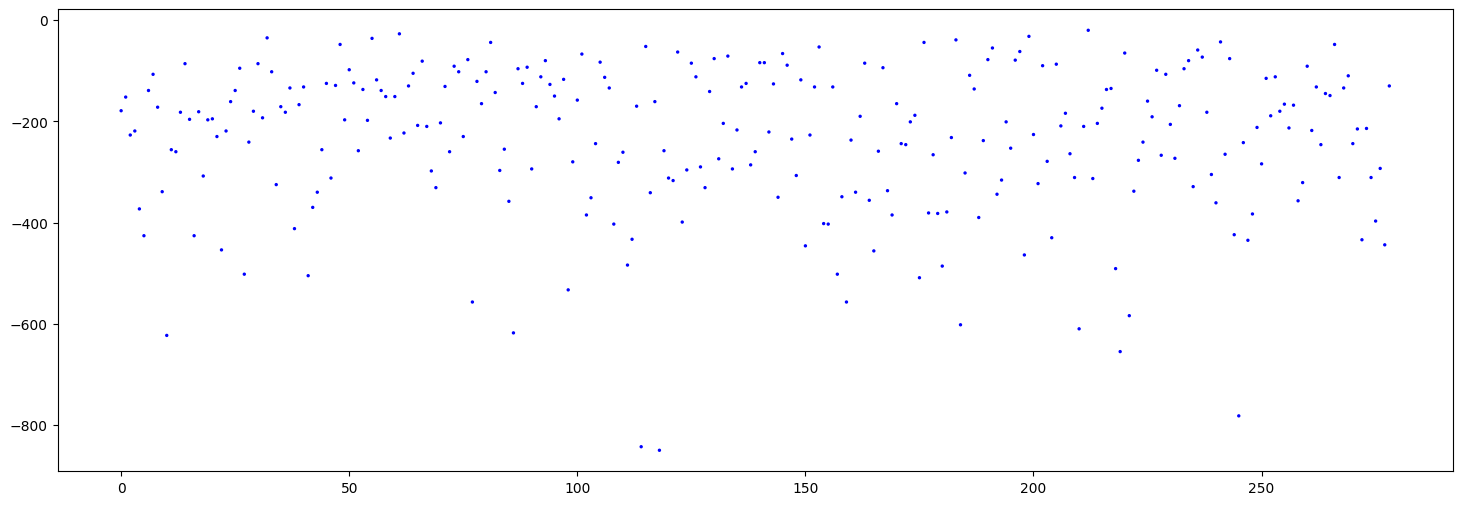

In [24]:
import matplotlib.pyplot as plt

x = list(range(len(env.all_rewards)))
y = env.all_rewards
s = [2] * len(x)
plt.figure(figsize=(18,6))
plt.scatter(x, y, c ="blue", s=s)
plt.show()

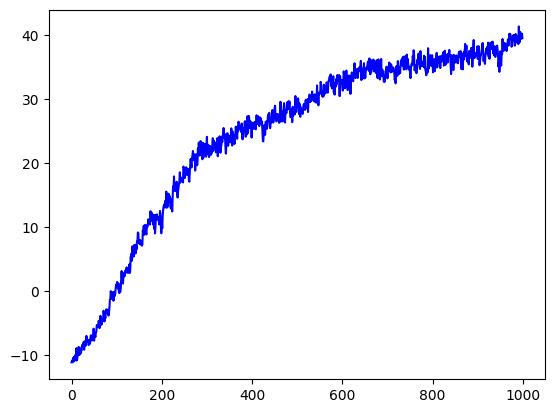

In [49]:
# Divide la lista en 100 sublistas
sublistas = np.array_split(env.all_rewards, 1000)

# Calcula la media de cada sublista y guarda en una nueva lista
medias = [np.mean(sublista) for sublista in sublistas]

x = list(range(len(medias)))
y = medias

plt.plot(x, y, c ="blue")

plt.show()


In [55]:
print(env.all_rewards)

[-19, -20, -20, -19, -17, -18, -24, -20, -18, -22, -23, -24, -17, -24, -16, -19, -17, -16, -19, -23, -22, -16, -17, -18, -23, -21, -20, -20, -16, -17, -17, -21, -22, -20, -21, -20, -19, -16, -22, -22, -23, -18, -19, -16, -24, -19, -21, -22, -19, -18, -17, -18, -16, -17, -19, -17, -22, -17, -18, -16, -21, -18, -17, -23, -19, -18, -20, -19, -12, -21, -20, -20, -16, -17, -16, -21, -20, -17, -19, -17, -18, -19, -23, -16, -20, -20, -16, -19, -24, -18, -22, -22, -21, -20, -22, -19, -23, -22, -22, -20, -21, -22, -22, -17, -23, -23, -18, -16, -19, -24, -21, -22, -21, -19, -16, -17, -17, -1, -17, -23, -17, -19, -24, -21, -24, -24, -22, -17, -18, -20, -22, -17, -22, -18, -20, -20, -16, -23, -20, -16, -21, -23, -16, -17, -17, -21, -22, -23, -17, -24, -17, -16, -19, -22, -24, -19, -19, -20, -19, -20, -22, -16, -22, -18, -24, -22, -16, -18, -24, -19, -21, -23, -24, -20, -18, -22, -19, -22, -22, -18, -22, -20, -19, -16, -19, -24, -20, -21, -18, -21, -24, -19, -22, -17, -13, -18, -21, -18, -20, -18, 

In [48]:
testing_env = OrganizationEnvironment(rendering=False)
testing_env.reset()
obs = testing_env._get_observation()

while True:
    action, _states = model.predict(obs)
    obs, reward, done, info = testing_env.step(action)
    print("\n\n")
    print("Acción:", action,"-> Reward:", reward)
    testing_env.render()
    if done == True:
        break




Acción: [6 5] -> Reward: 2
		 Desafíos			 Preferencias
Alumno 0: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 2, 3, 0, 0, 0, 4, 1, 5]
Alumno 1: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [2, 3, 4, 0, 0, 5, 1, 0, 0]
Alumno 2: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [1, 2, 5, 0, 4, 0, 0, 0, 3]
Alumno 3: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [5, 1, 0, 0, 0, 2, 3, 4, 0]
Alumno 4: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 0, 5, 0, 1, 2, 3, 4, 0]
Alumno 5: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 5, 2, 0, 0, 0, 4, 1, 3]
Alumno 6: 	 [0, 0, 0, 0, 0, 1, 0, 0, 0] 	 [2, 0, 3, 0, 0, 5, 1, 0, 4]
Alumno 7: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 4, 2, 0, 5, 1, 3, 0, 0]
Alumno 8: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [1, 0, 5, 2, 3, 0, 0, 4, 0]
Alumno 9: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 2, 3, 0, 4, 1, 0, 0, 5]
Alumno 10: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 3, 0, 2, 4, 5, 0, 0, 1]
Alumno 11: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [4, 2, 0, 0, 3, 1, 0, 5, 0]



Acción: [10  5] -> Reward: 2
		 Desafíos			 Preferencias
Alumno 0: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 

In [2]:
import json

# El JSON proporcionado (corrigiendo el problema de la clave duplicada)
json_data = {
    "0": [0, 0, 0, 0, 1, 2, 3, 0, 0],
    "1": [2, 3, 0, 0, 0, 0, 1, 0, 0],
    "2": [1, 2, 0, 0, 0, 0, 0, 0, 3],
    "3": [0, 1, 0, 0, 0, 2, 3, 0, 0],
    "6": [0, 0, 2, 0, 0, 0, 0, 1, 3],
    "7": [0, 0, 2, 0, 0, 1, 3, 0, 0],
    "8": [1, 0, 0, 2, 3, 0, 0, 0, 0],
    "9": [0, 2, 3, 0, 0, 1, 0, 0, 0],
    "10": [0, 3, 0, 2, 0, 0, 0, 0, 1],
    "11": [0, 2, 0, 0, 3, 1, 0, 0, 0]
}

# Crear una lista de listas a partir del JSON
keys = sorted(map(int, json_data.keys()))  # Ordenar claves numéricas
lista_final = [json_data[str(key)] for key in keys]
print(lista_final)

[[0, 0, 0, 0, 1, 2, 3, 0, 0], [2, 3, 0, 0, 0, 0, 1, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 3], [0, 1, 0, 0, 0, 2, 3, 0, 0], [0, 0, 2, 0, 0, 0, 0, 1, 3], [0, 0, 2, 0, 0, 1, 3, 0, 0], [1, 0, 0, 2, 3, 0, 0, 0, 0], [0, 2, 3, 0, 0, 1, 0, 0, 0], [0, 3, 0, 2, 0, 0, 0, 0, 1], [0, 2, 0, 0, 3, 1, 0, 0, 0]]
